#1.0 Hybrid Images (10 points)
Recall the hybrid image of Albert Einstein and Marilyn Monroe introduced in [1] and
reproduced below in Fig. 1. Due to the way your brain processes spatial frequencies, you
will see the identity of the image change if you squint or move farther/closer to the image.
In this problem, you will create your own hybrid image.

In [ ]:
from PIL import Image
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import butter, filtfilt, find_peaks
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1.1 Gaussian kernel
Implement function **gaussian2D(sigma, kernel_size)** that returns a 2D gaussian blur kernel, with input argument **sigma** specifying a tuple of x,y scales (standard deviations), and **kernel_size** specifying a tuple of x,y dimensions of the kernel. The kernel should be large enough to include 3 standard deviations per dimension.

In [ ]:
def gaussian2D(sigma, kernel_size):
  # Unpack the size of the kernel into x_size and y_size
  x_size, y_size = kernel_size

  # Calculate the limits of x and y for the kernel
  x_limits = (x_size - 1) / 2
  y_limits = (y_size - 1) / 2

  # Create a 2D grid of values for x and y
  x, y = np.mgrid[-x_limits:x_limits+1, -y_limits:y_limits+1]

  # Apply Gaussian filter (lowpass) from Lec 6.
  kernel = (1 / (2 * np.pi * sigma * sigma)) * np.exp(- (np.square(x) / (2 * np.square(sigma)) + np.square(y) / (2 * np.square(sigma))))
  
  # Normalize the values of the 2D Gaussian kernel so that their sum is 1
  kernel = kernel / np.sum(kernel)
  
  return kernel

##1.2 Create Hybrid Images
Choose two images (**A** and **B**) of your choice that you will blend with one another and convert them to grayscale (you can use **opencv.cvtColor**). These images can be of faces, or any other objects. Try to make the objects in the two images occupy roughly the same region in the image (if they don’t you can use the **imwarp** function you wrote in Homework 1 to manually align them!).

Construct a hybrid image **C** from **A** (to be seen close-up) and **B** (to be seen far away) as follows: **C = blur(B) + (A-blur(A))**, where **blur** is a function that lowpass filters the image (use the Gaussian kernel you coded in 1.1 for this). Try different values of **sigma** for the Gaussian kernel. How does the amount of blurring affect your perception of the results? In your report, please show your input images labeled clearly as **A** and **B**, and attach the result **C** for a value of **sigma** which you feel demonstrates the illusion the best, at both the original size and a downsampled size. As a sanity check, you should be able to see the identity change when looking at the original and downsampled versions.

In [ ]:
def blur(img, sigma, kernel_size):
  kernel = gaussian2D(sigma, kernel_size)
  filtered_img = cv2.filter2D(img, -1, kernel)
  return filtered_img

def hybrid_image(A, B, sigma, kernel_size):
  # Convert A and B to grayscale
  A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
  B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

  # Blur A and B
  A_blur = blur(A_gray, sigma, kernel_size)
  B_blur = blur(B_gray, sigma, kernel_size)

  # Construct hybrid image
  C = B_blur + (A_gray - A_blur)

  return C

<Figure size 432x288 with 0 Axes>

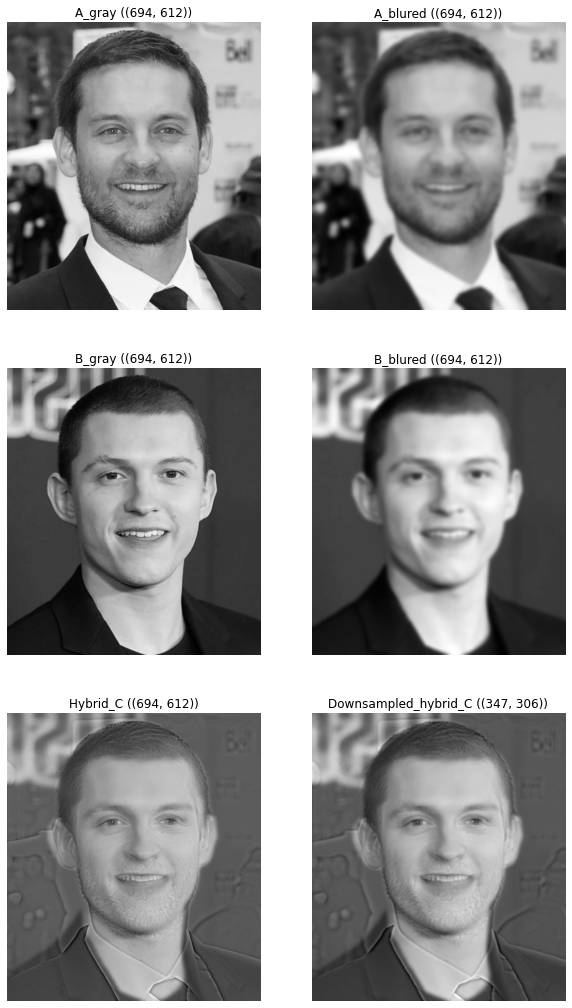

In [ ]:
if __name__ == "__main__":
  # Load A and B images, and convert the image to a numpy array with floating-point values, and convert them to grayscale
  A = Image.open(path + 'tobey_maguire.jpg')
  A = np.array(A, dtype=np.float32)
  A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
  B = Image.open(path + 'tom_holland.jpg')
  B = np.array(B, dtype=np.float32)
  B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
    
  # Define sigma and kernel size values
  sigma = 4
  kernel_size = (6*sigma, 6*sigma)

  # Blur A and B images
  A_blur = blur(A_gray, sigma, kernel_size)
  B_blur = blur(B_gray, sigma, kernel_size)
  
  # Calculate the hybrid C image
  hybrid_C = hybrid_image(A, B, sigma, kernel_size)

  # Downsample C
  C_downsampled = cv2.pyrDown(hybrid_C)
  
  # Show the A_gray, B_gray, A_blured, B_blured, Hybrid_C and Downsample_hybrid_C images
  plt.figure()
  fig, ax = plt.subplots(3, 2, figsize=(10, 18)) 
  output_images = [A_gray, A_blur, 
            B_gray, B_blur,
            hybrid_C, C_downsampled]
  titles = ['A_gray', 'A_blured', 
        'B_gray', 'B_blured', 
        'Hybrid_C', 'Downsampled_hybrid_C']
  index = 0
  for i in range(3):
    for j in range(2):
      ax[i][j].imshow(output_images[index], cmap="gray")
      ax[i][j].axis('off')
      ax[i][j].set_title(f"{titles[index]} ({output_images[index].shape})")
      index += 1

##1.3 Fourier Spectra
For the **sigma** value you chose in 1.2, show images of the Fourier spectra magnitudes of images **A, B, blur(B), A-blur(A), and C**. You can get the magnitude of the Fourier spectrum coefficients of an image ‘x’ by running:
**X = numpy.abs(numpy.fftshift(numpy.fft2(x)))**

By default, **numpy.fft2** will place the zero frequency (DC component) of the spectrum at the top left of the image, and so **numpy.fftshift** is used here to place the zero frequency at the center of the image. When displaying the Fourier spectrum with **matplotlib.pyplot.imshow**, the image will likely look black. This is because the DC component typically has a much higher magnitude than all other frequencies, such that after rescaling all values to lie in [0,1], most of the image is close to 0. To overcome this, display the logarithm of the values instead.

In [ ]:
def fourier_spectrum_magnitude(img):
  # Get the Fourier spectrum magnitude of the image
  spectrum = np.abs(np.fft.fftshift(np.fft.fft2(img)))
  spectrum = np.log(spectrum)
  return spectrum

<Figure size 432x288 with 0 Axes>

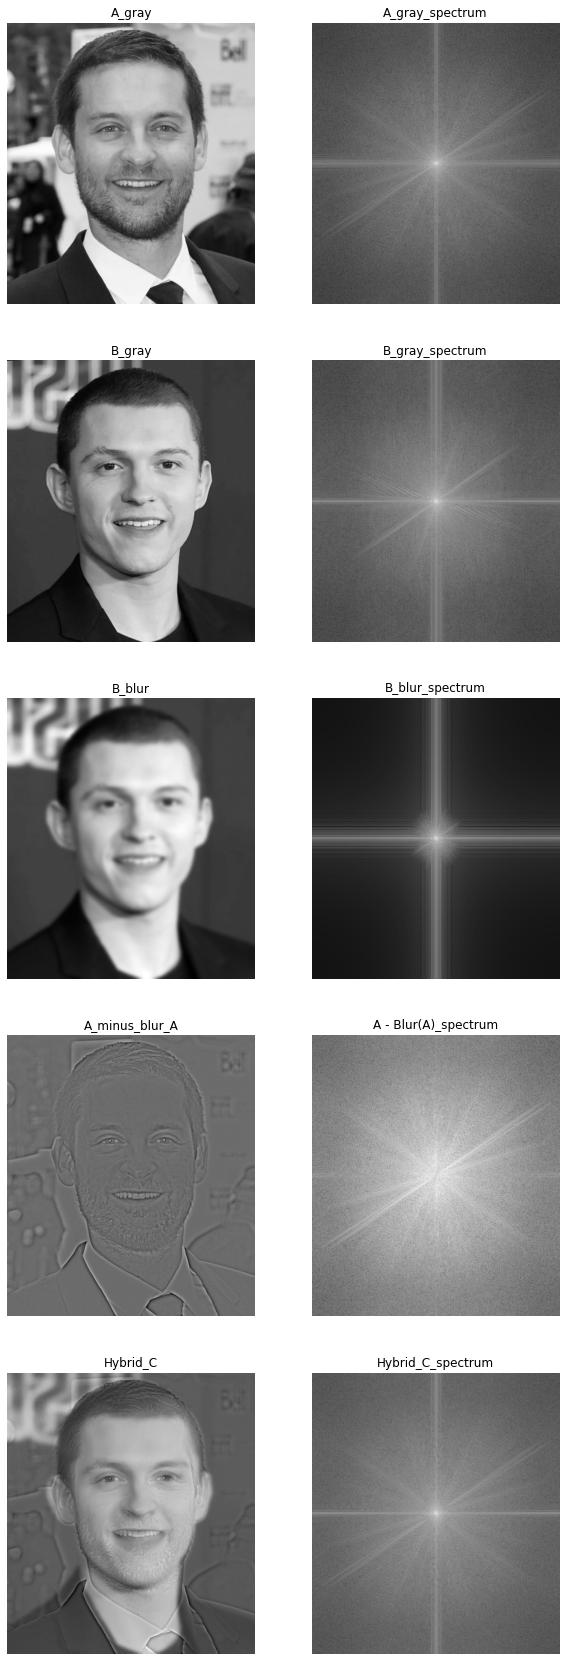

In [ ]:
if __name__ == "__main__":
  # Load A and B images, and convert the image to a numpy array with floating-point values, and convert them to grayscale
  A = Image.open(path + 'tobey_maguire.jpg')
  A = np.array(A, dtype=np.float32)
  A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
  B = Image.open(path + 'tom_holland.jpg')
  B = np.array(B, dtype=np.float32)
  B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
  
  # Define sigma and kernel size values
  sigma = 4
  kernel_size = (6*sigma, 6*sigma)

  # Blur B
  B_blur = blur(B_gray, sigma, kernel_size)
  
  # Get A - blur(A)
  A_minus_blur_A = A_gray - blur(A_gray, sigma, kernel_size)
  
  # Get the hybrid image
  Hybrid_C = hybrid_image(A, B, sigma, kernel_size)
  
  # Get the Fourier spectra magnitudes of A, B, blur(B), A-blur(A), and C
  A_gray_spectrum = fourier_spectrum_magnitude(A_gray)
  B_gray_spectrum = fourier_spectrum_magnitude(B_gray)
  B_blur_spectrum = fourier_spectrum_magnitude(B_blur)
  A_minus_blur_A_spectrum = fourier_spectrum_magnitude(A_minus_blur_A)
  Hybrid_C_spectrum = fourier_spectrum_magnitude(Hybrid_C)

  # Display the Fourier spectra magnitudes of A, B, blur(B), A-blur(A), and C
  plt.figure()
  fig, ax = plt.subplots(5, 2, figsize=(10, 30)) 
  output_images = [A_gray, A_gray_spectrum, 
            B_gray, B_gray_spectrum,
            B_blur, B_blur_spectrum,
            A_minus_blur_A, A_minus_blur_A_spectrum,
            Hybrid_C, Hybrid_C_spectrum]
  titles = ['A_gray', 'A_gray_spectrum', 
        'B_gray', 'B_gray_spectrum', 
        'B_blur', 'B_blur_spectrum', 
        'A_minus_blur_A', 'A - Blur(A)_spectrum', 
        'Hybrid_C', 'Hybrid_C_spectrum']
  index = 0
  for i in range(5):
    for j in range(2):
      ax[i][j].imshow(output_images[index], cmap="gray")
      ax[i][j].axis('off')
      ax[i][j].set_title(titles[index])
      index += 1

#2.0 Laplacian Blending (15 points)
The Laplacian pyramid is a useful tool for many computer vision and image processing applications. One such application is blending sections of different images together, as shown in Fig. 2. In this problem, you will write code that constructs a Laplacian pyramid, and use it to blend two images of your choice together.

##2.1 Gaussian Pyramid
Write a function **gausspyr(I, n_levels, sigma)**that returns a Gaussian pyramid for image **I** with number of levels **n_levels** and Gaussian kernel scale **sigma**. The function should return a list of images, with element **i** corresponding to level **i** of the pyramid. Note that level **0** should correspond to the original image **I**, and level **n_levels - 1** should correspond to the coarsest (lowest frequency) image.

In [ ]:
def downsample(img):
  # Downsample the image by taking every other row and column
  return img[::2, ::2, :]

def gausspyr(I, n_levels, sigma):
  # Create a list to store the pyramid levels
  pyramid = []

  pyramid.append(I)

  for i in range(n_levels):
    # Blur the current level of the pyramid
    blurred = blur(I, sigma, kernel_size=(int(6*sigma), int(6*sigma)))

    # Downsample the blurred image
    downsampled = downsample(blurred)

    # Add the downsampled image to the pyramid
    pyramid.append(downsampled)
    I = downsampled

  return pyramid

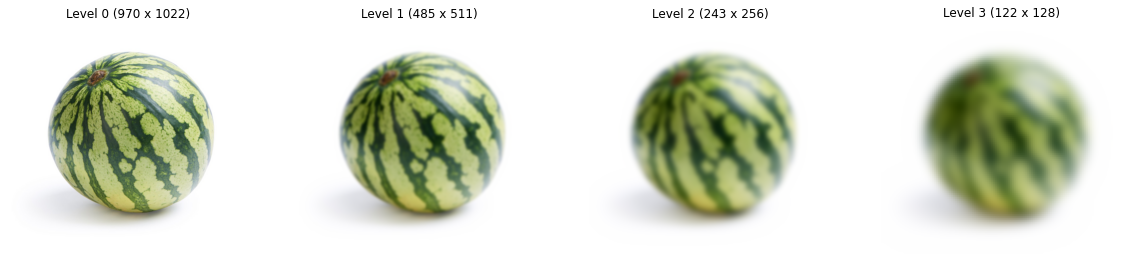

In [ ]:
if __name__ == "__main__":
  # Load the image from the file, and convert the image to a numpy array with floating-point values
  A = Image.open(path + 'watermelon.jpg')
  A = np.array(A, dtype=np.float32)

  # Define the number of levels and sigma for the pyramid
  n_levels = 3
  sigma = 5

  # Apply the Gaussian pyramid function to the image
  pyramid = gausspyr(A, n_levels, sigma)

  # Display each level of the pyramid
  fig, axs = plt.subplots(1, len(pyramid), figsize=(20, 20))
  for i, level in enumerate(pyramid):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    axs[i].imshow(level)
    axs[i].set_title("Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    axs[i].axis('off')

##2.2 Laplacian Pyramid
Write a function **lappyr(I, n_levels, sigma)**that returns a Laplacian pyramid for image **I** with number of levels **n_levels** and Gaussian kernel **sigma**. The function should return a list of images, with element **i** corresponding to level **i** of the pyramid. Note that level **0** corresponds to the details of the original image **I**, and level **n_levels - 1** corresponds to the low-frequency residual image.

In [ ]:
def convolution(img):
  kernel = np.array([[0.25, 0.5, 0.25], 
            [0.5, 1, 0.5], 
            [0.25, 0.5, 0.25]])
  # Apply convolution to the input image
  convoluted = cv2.filter2D(img, -1, kernel)
  return convoluted

def upsample(img):
  # Create an empty image with double the size in both dimensions
  upsampled = np.zeros([img.shape[0] * 2, img.shape[1] * 2, img.shape[2]])

  # Copy values from the original image to every other row and column in the upsampled image
  upsampled[::2, ::2, :] = img[::1, ::1, :]

  # Return the upsampled image
  return upsampled

def lappyr(I, n_levels, sigma):
  # Create a list to store the pyramid levels
  pyramid = []

  # pyramid.append(I)

  for i in range(n_levels):
    # Apply Gaussian blur to the current level
    gaussianed = blur(I, sigma, kernel_size=(int(6*sigma), int(6*sigma)))
    # Downsample the blurred image
    downsampled = downsample(gaussianed)
    # Upsample the downsampled image
    upsampled = upsample(downsampled)
    # Perform convolution on the upsampled image
    convoluted = convolution(upsampled)
    # Compute the Laplacian level by subtracting the convoluted image from the original level
    L = I - convoluted
    # Append the Laplacian level to the pyramid
    pyramid.append(L)

    # Check if we have reached the last level
    if i == n_levels-1:
      # Append the downsampled image to the pyramid
       pyramid.append(downsampled)
    # Set the current level to the downsampled image for the next iteration
    I = downsampled
  return pyramid

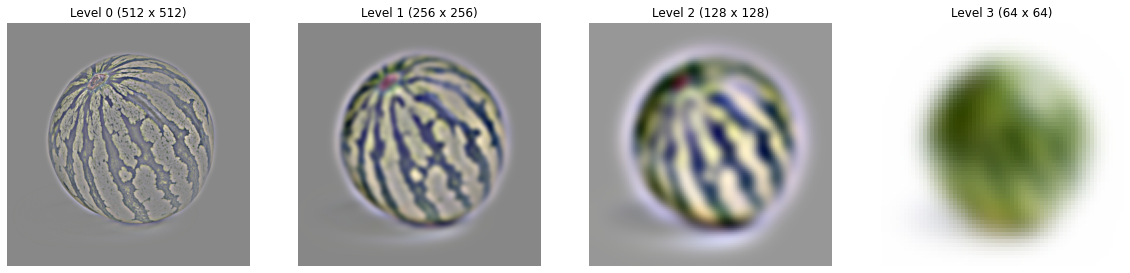

In [ ]:
if __name__ == "__main__":
  # Open the image and convert it to a numpy array with data type float32
  A = Image.open(path + 'watermelon.jpg')
  A = np.array(A, dtype=np.float32)
  # Normalize the image intensity values by dividing by 255.0
  A = (A / 255.0)
  # Resize the image to 512x512
  A = cv2.resize(A, (512, 512))
  # Convert the image from RGBA to RGB
  A = cv2.cvtColor(A, cv2.COLOR_RGBA2RGB)

  # Define the number of levels and sigma for the pyramid
  n_levels = 3
  sigma = 5

  # Apply the Laplacian pyramid function to the image
  pyramid = lappyr(A, n_levels, sigma)

  # Display each level of the pyramid
  fig, axs = plt.subplots(1, len(pyramid), figsize=(20, 20))
  for i, level in enumerate(pyramid):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    axs[i].imshow(level)
    axs[i].set_title("Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    axs[i].axis('off')

##2.3 Image Blending
Choose two images A and B depicting different objects and resize them to the same shape. You may want to use your **imwarp** function from Homework 1 to align the scales/orientations of the objects appropriately (as was done in the example in Fig. 2) so that the resulting blend will be most convincing. Create a binary mask image **mask** which will have 1s in its left half, and 0s in its right half (called a ‘step’ function). Perform blending with the following operations:


1.   Build Laplacian pyramids for **A** and **B**.
2.   Build a Gaussian pyramid for **mask**.
3.   Build a blended Laplacian pyramid for output image **C** using pyramids of **A, B**, and **mask**, where each level **𝑙c𝑘** is defined by the equation **𝑙K = 𝑙A ∗ 𝑚 + 𝑙B ∗ (1 − 𝑚)**.
4.  Invert the combined Laplacian pyramid back into an output image **C**.

Show the following in your report: (1) Images from all levels of the Laplacian pyramids for **A** and **B**, (2) images from all levels of the Gaussian pyramid for **mask**, and (3) your final blended image **C**.

In [ ]:
# 02/13/2023 start from here to debug...........................................
def invert(levels, n_levels, sigma):
  """
    Parameters:
        levels (list): A list of Laplacian pyramid levels.
        n_levels (int): The number of levels in the pyramid.
        sigma (float): The standard deviation of the Gaussian filter.
    
    Returns:
        list: The reconstructed image.
    """
  
  # Create a list to store the inverted levels
  inverted = []

  res_img = levels[-1]

  for i in range(len(levels)-2, -1, -1):
    upsampled = upsample(res_img)
    upsampled = convolution(upsampled)
    result = upsampled + levels[i]
    inverted.append(result)
    res_img = result
  return inverted

def image_blending(A, B, mask, n_levels, sigma):
  """
    Parameters:
        A (list): A list of Laplacianed Image A.
        B (list): A list of Laplacianed Image B.
        mask (list): A list of Gaussianed mask.
        n_levels (int): The number of levels in the pyramid.
        sigma (float): The standard deviation of the Gaussian filter.
    
    Returns:
        list: The blended image.
    """
  # Create a list to store blended Laplacian pyramid for the output image C
  blended_pyramid = []

  # For each level of the pyramid (from 0 to n_levels + 2)
  for i in range(0, n_levels + 2):
    # Combine the current level of the Laplacian pyramid from image A and B, using the mask
    C = A[i] * mask[i] + B[i] * (1.0 - mask[i])
    # Add the blended level to the list of blended levels
    blended_pyramid.append(C)

  # Invert the combined Laplacian pyramid back into an output image C
  output_C = invert(blended_pyramid, n_levels, sigma)

  return output_C

<Figure size 432x288 with 0 Axes>

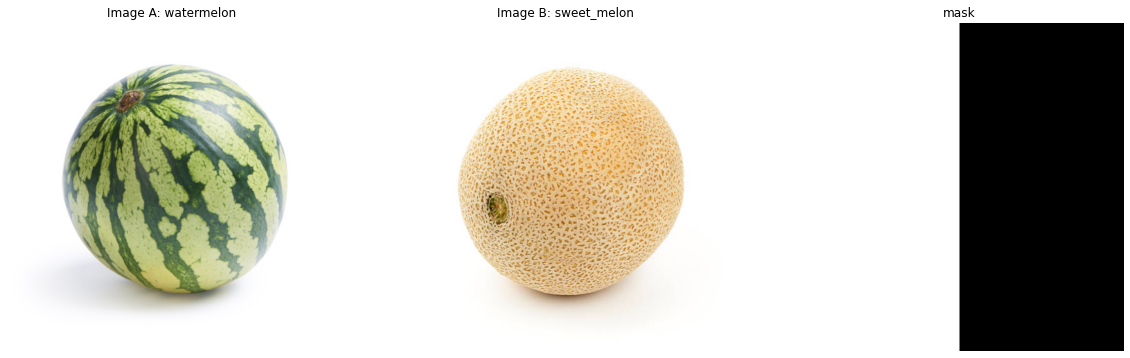

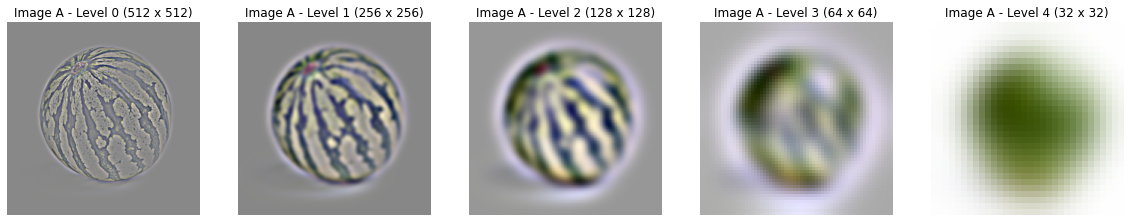

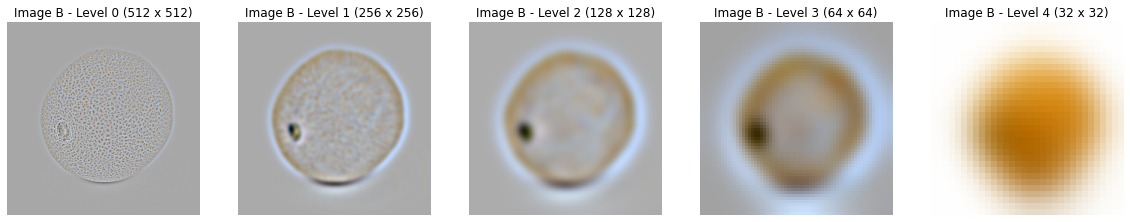

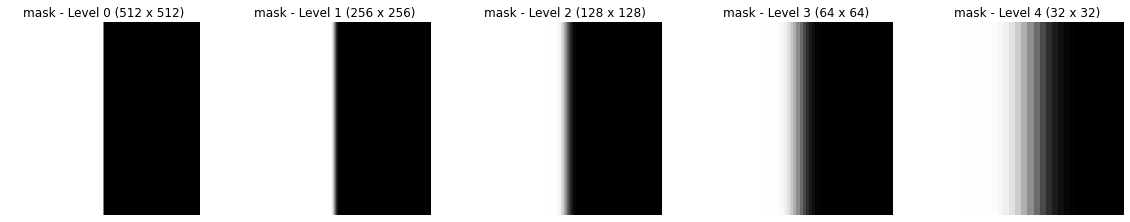

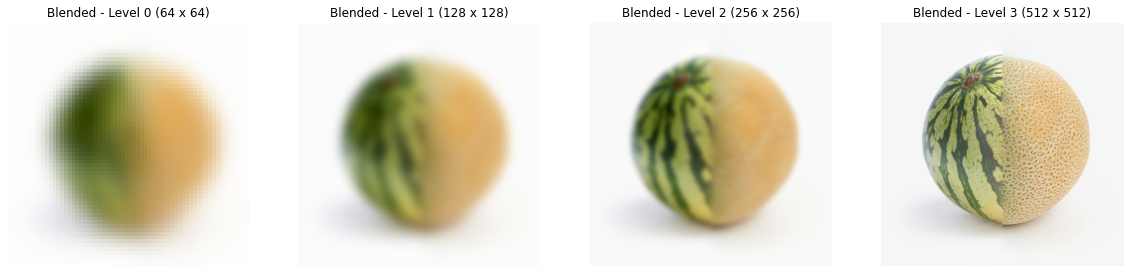

In [ ]:
if __name__ == "__main__":
  # Open the A image and convert it to a numpy array with data type float32, then normalize and resize
  A = Image.open(path + 'watermelon.jpg')
  A = np.array(A, dtype=np.float32)
  A = (A / 255.0)
  A = cv2.resize(A, (512, 512))

  # Open the B image and convert it to a numpy array with data type float32, then normalize and resize
  B = Image.open(path + 'sweet_melon.jpg')
  B = np.array(B, dtype=np.float32)
  B = (B / 255.0)
  B = cv2.resize(B, (512, 512))

  # Build the binary mask
  mask = np.zeros(A.shape, dtype=np.float32)
  mask[:, :A.shape[1] // 2] = 1
  mask = cv2.resize(mask, (512, 512))

  # Display image A, B and mask
  plt.figure()
  fig, ax = plt.subplots(1, 3, figsize=(20, 20)) 
  output_images = [A, B, mask]
  titles = ['Image A: watermelon', 'Image B: sweet_melon', 'mask']
  index = 0
  for i in range(3):
    ax[i].imshow(output_images[index], cmap="gray")
    ax[i].axis('off')
    ax[i].set_title(titles[i])
    index += 1

  # Define the number of levels for the pyramid
  n_levels = 3
  sigma = 5

  # Build Laplacian pyramids for A and B
  laplacian_A = lappyr(A, n_levels+1, sigma)
  laplacian_B = lappyr(B, n_levels+1, sigma)

  # Build a Gaussian pyramid for the mask
  gaussian_mask = gausspyr(mask, n_levels+1, sigma)

  # Display each level of the Image A's Lapacian Pyramid
  fig, bx = plt.subplots(1, len(laplacian_A), figsize=(20, 20))
  for i, level in enumerate(laplacian_A):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    bx[i].imshow(level)
    bx[i].set_title("Image A - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    bx[i].axis('off')

  # Display each level of the Image B's Lapacian Pyramid
  fig, cx = plt.subplots(1, len(laplacian_B), figsize=(20, 20))
  for i, level in enumerate(laplacian_B):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    cx[i].imshow(level)
    cx[i].set_title("Image B - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    cx[i].axis('off')

  # Display each level of the mask's Gaussian Pyramid
  fig, dx = plt.subplots(1, len(gaussian_mask), figsize=(20, 20))
  for i, level in enumerate(gaussian_mask):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    dx[i].imshow(level)
    dx[i].set_title("mask - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    dx[i].axis('off')

  blended_pyramid = image_blending(laplacian_A, laplacian_B, gaussian_mask, n_levels, sigma)

  # Display each level of the Blended Pyramid
  fig, ex = plt.subplots(1, len(blended_pyramid), figsize=(20, 20))
  for i, level in enumerate(blended_pyramid):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    ex[i].imshow(level)
    ex[i].set_title("Blended - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    ex[i].axis('off')

##2.4 Blending two images with a mask other than a step
Laplacian blending is not restricted to only combining halves of two images using a step mask. You can set the mask to any arbitrary function and merge images, as shown in **this example**. Demonstrate a Laplacian blend of two new images using a mask other than step.

In [ ]:
def create_oval_mask(shape, center, width, height):
  # Generate a 2D meshgrid for the image shape
  y, x = np.ogrid[:shape[0], :shape[1]]
  # Define the center of the oval
  cy, cx = center
  # Create a mask based on the oval shape using the given center, width and height
  mask = ((x - cx) / (width / 2))**2 + ((y - cy) / (height / 2))**2
  # Convert the mask to binary with values either 0 or 1, then resize the image
  binary_mask = (mask <= 1).astype(np.float32)
  binary_mask = cv2.resize(binary_mask, (512, 512))

  # Add an additional dimension to the binary mask to support 3 channels for RGB images
  binary_mask = np.expand_dims(binary_mask, axis=-1)
  # Concatenate the binary mask along the channel dimension to form a 3-channel mask
  binary_mask = np.concatenate([binary_mask, binary_mask, binary_mask], axis=-1)
  return binary_mask

<Figure size 432x288 with 0 Axes>

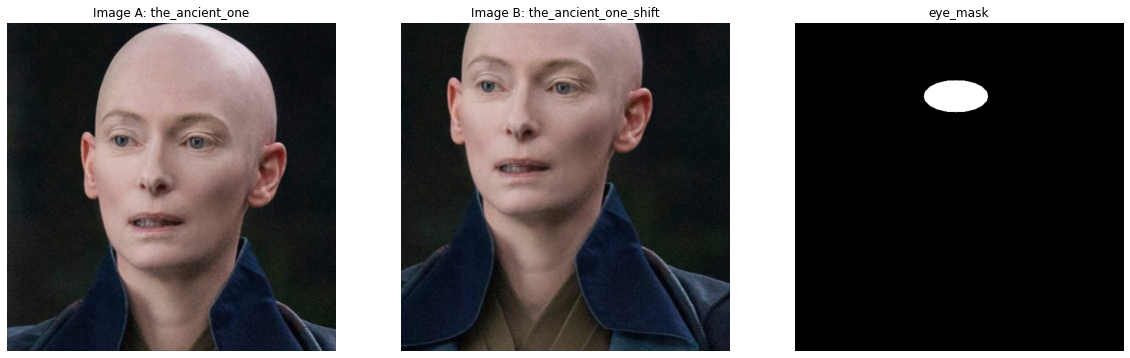

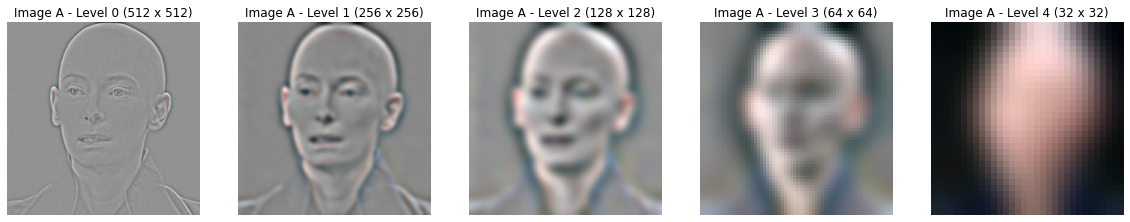

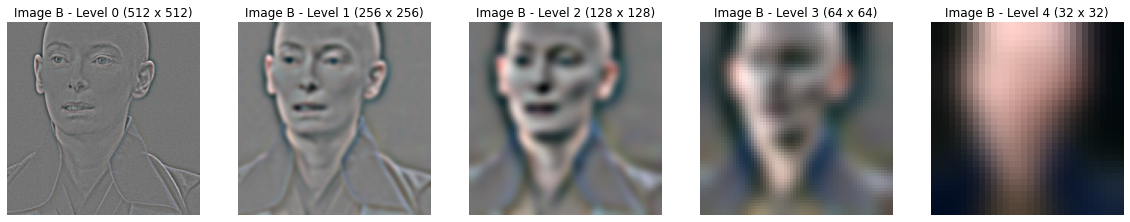

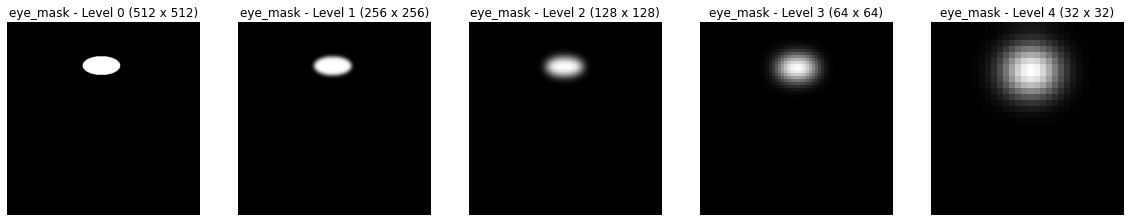

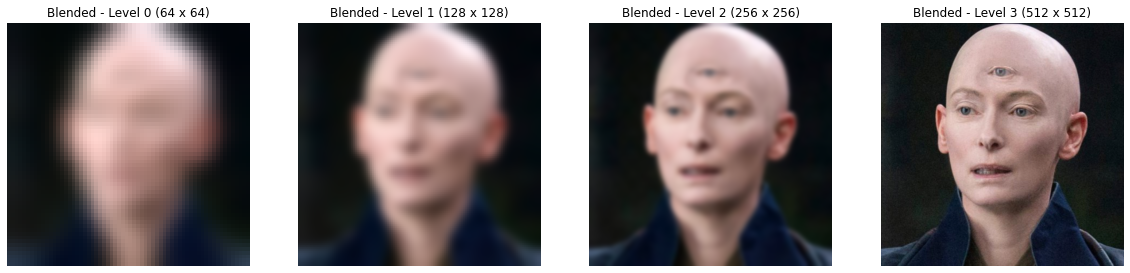

In [ ]:
if __name__ == "__main__":
  # Open the A image and convert it to a numpy array with data type float32, then normalize and resize
  A = Image.open(path + 'the_ancient_one.jpg')
  A = np.array(A, dtype=np.float32)
  A = (A / 255.0)
  A = cv2.resize(A, (512, 512))

  # Open the B image and convert it to a numpy array with data type float32, then normalize and resize
  B = Image.open(path + 'the_ancient_one_shift.jpg')
  B = np.array(B, dtype=np.float32)
  B = (B / 255.0)
  B = cv2.resize(B, (512, 512))

  # Build the oval binary mask
  eye_mask = create_oval_mask(shape = (512, 512), center = (115, 250), width = 100, height = 50)

  # Display image A, B and mask
  plt.figure()
  fig, ax = plt.subplots(1, 3, figsize=(20, 20)) 
  output_images = [A, B, eye_mask]
  titles = ['Image A: the_ancient_one', 'Image B: the_ancient_one_shift', 'eye_mask']
  index = 0
  for i in range(3):
    ax[i].imshow(output_images[index], cmap="gray")
    ax[i].axis('off')
    ax[i].set_title(titles[i])
    index += 1

  # Define the number of levels for the pyramid
  n_levels = 3
  sigma = 5

  # Build Laplacian pyramids for A and B
  laplacian_A = lappyr(A, n_levels+1, sigma)
  laplacian_B = lappyr(B, n_levels+1, sigma)

  # Build a Gaussian pyramid for the mask
  gaussian_mask = gausspyr(eye_mask, n_levels+1, sigma)

  # Display each level of the Image A's Lapacian Pyramid
  fig, bx = plt.subplots(1, len(laplacian_A), figsize=(20, 20))
  for i, level in enumerate(laplacian_A):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    bx[i].imshow(level)
    bx[i].set_title("Image A - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    bx[i].axis('off')

  # Display each level of the Image B's Lapacian Pyramid
  fig, cx = plt.subplots(1, len(laplacian_B), figsize=(20, 20))
  for i, level in enumerate(laplacian_B):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    cx[i].imshow(level)
    cx[i].set_title("Image B - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    cx[i].axis('off')

  # Display each level of the mask's Gaussian Pyramid
  fig, dx = plt.subplots(1, len(gaussian_mask), figsize=(20, 20))
  for i, level in enumerate(gaussian_mask):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    dx[i].imshow(level)
    dx[i].set_title("eye_mask - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    dx[i].axis('off')

  blended_pyramid = image_blending(laplacian_B, laplacian_A, gaussian_mask, n_levels, sigma)

  # Display each level of the Blended Pyramid
  fig, ex = plt.subplots(1, len(blended_pyramid), figsize=(20, 20))
  for i, level in enumerate(blended_pyramid):
    level = (level.astype(np.float32) - level.min()) / (level.max() - level.min())
    ex[i].imshow(level)
    ex[i].set_title("Blended - Level {} ({} x {})".format(i, level.shape[0], level.shape[1]))
    ex[i].axis('off')

#3.0 Pulse Estimation from Video (5 points)
You are convinced that your friend Alice is a robot. You don’t have much evidence to prove this because she is quite a convincing human during conversations, except for the fact that she does get very angry if water touches her. One day, you hit upon a plan to
figure out this mystery once and for all. You know that a human has a heart which pumps blood, and a robot does not. Furthermore, you read a paper [2] showing that one can estimate heart rate from a video of a human face using very simple computer vision techniques. So the next day, you convince Alice to take this video of herself, **linked here**.
You will now need to implement a simple pulse estimation algorithm and run it on the video. Follow these steps:

##3.1 Read video into notebook and define regions of interes
Upload the video into your Colab environment. Note that it may take several minutes for the upload to complete due to the size of the file. You can then read the video frames into a numpy array using the **read_video_into_numpy** function provided **here**.

Using the first video frame, manually define rectangles (row and column boundaries) that capture 1) one of the cheeks and 2) the forehead.

In [ ]:
def read_video_into_numpy(filename):
  """
  Parameters:
    filename (str): The path to the video file to be read.

  Returns:
    frames (list): A list of numpy arrays representing each frame in the video.
  """
  cap = cv2.VideoCapture(filename)
  frames = []
  while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
      print("Can't receive frame (stream end?). Exiting ...")
      break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

  cap.release()
  video = np.stack(frames, axis=0)#converts to numpy array(T,H,W,C)
  video = np.transpose(video, (1,2,3,0))#(T,H,W,C)->(H,W,C,T)
  return frames


def bandpass_filter(signal, low_cutoff, high_cutoff, fs, order):
  nyquist = 0.5 * fs
  low = low_cutoff / nyquist
  high = high_cutoff / nyquist
  b, a = butter(order, [low, high], btype='band')
  filtered_signal = filtfilt(b, a, signal)
  
  return filtered_signal

In [ ]:
def extract_image(video, x, y):
  """
  Parameters:
    video (list): A list of numpy arrays representing each frame in the video.
    x (list): ↕ [a-axis]
    y (list): ↔ [y-axis]

  Returns:
    extracted_img (list): extracted image from 1st frame in the video.
  """

  extracted_img = video[0][x[0]:x[1], y[0]:y[1], :]
  return extracted_img

Can't receive frame (stream end?). Exiting ...


<Figure size 432x288 with 0 Axes>

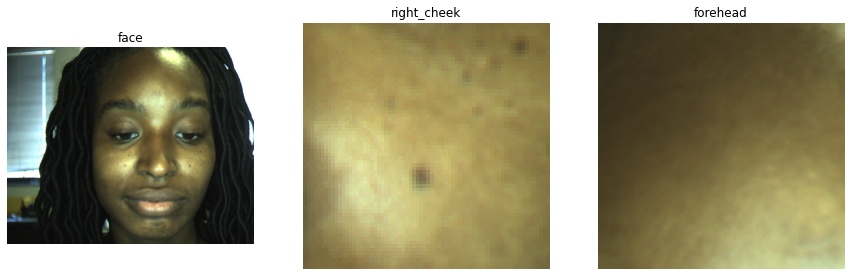

In [ ]:
if __name__ == "__main__":
  # read video into numpy array
  alice_video = read_video_into_numpy(path+"alice.avi")

  # get 1st frame of the video
  face = alice_video[0]

  # extract the cheek and forehead portions of the first frame of the video
  right_cheek = extract_image(video = alice_video, x = [265,335], y = [440,510])
  forehead = extract_image(video = alice_video, x = [30,130], y = [300,400])
  
  # Display image face, right_cheek and forehead
  plt.figure()
  fig, ax = plt.subplots(1, 3, figsize=(15, 15)) 
  output_images = [face, right_cheek, forehead]
  titles = ['face', 'right_cheek', 'forehead']
  index = 0
  for i in range(3):
    ax[i].imshow(output_images[index], cmap="gray")
    ax[i].axis('off')
    ax[i].set_title(titles[i])
    index += 1

##3.2 Compute signals
Now compute the average Green value of pixels for all frames for each facial region (cheek, forehead). This gives a 1D signal in time called the Photoplethysmogram (PPG) for each region.

In [ ]:
def compute_signals(video, x, y):
  '''
  Parameters:
    video (np.ndarray): A 4-D numpy array representing a video, with shape (T, H, W, C), where T is the number of frames, H is the height, W is the width, and C is the number of channels (usually 3 for RGB).
    x (list): A list of two integers, specifying the starting and ending row indices of the region of interest.
    y (list): A list of two integers, specifying the starting and ending column indices of the region of interest.

  Returns:
    Green_img (np.ndarray): The green channel of the region of interest in one of the video frames.
    Green_Avg (list): A list of the average values of the green channel in the region of interest, computed over all video frames.
  '''
  
  Green_Avg = []
  for frame in video:
    Green_img = frame[x[0]:x[1], y[0]:y[1], :].copy()
    Green_img[:, :, ::2] = 0
    Green_Avg.append(np.mean(Green_img[:, :, 1]))

  return Green_img, Green_Avg

<Figure size 432x288 with 0 Axes>

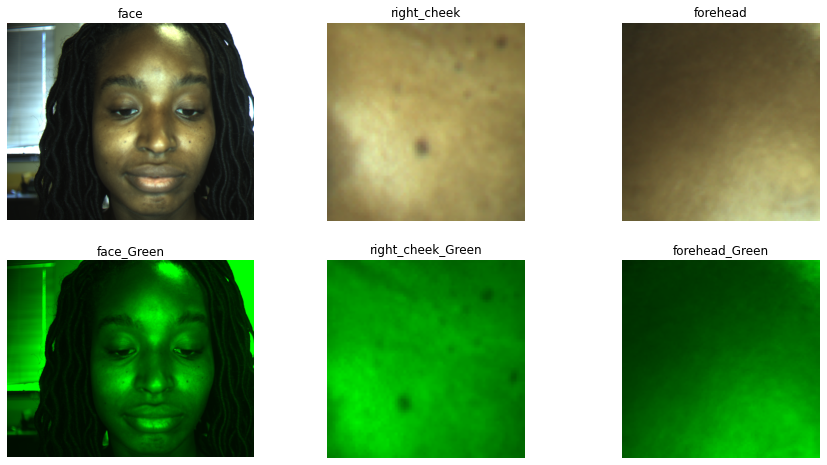

In [ ]:
if __name__ == '__main__':
  # Compute green signals from the Alice video for different regions: face, right cheek, and forehead
  face_Green_Avg = compute_signals(video = alice_video, x = [0,512], y = [0,640])
  right_cheek_Green_Avg = compute_signals(video = alice_video, x = [265,335], y = [440,510])
  forehead_Green_Avg = compute_signals(video = alice_video, x = [30,130], y = [300,400])

  # Display image face_Green, right_cheek_Green and forehead_Green
  plt.figure()
  fig, ax = plt.subplots(2, 3, figsize=(15, 8)) 
  output_images = [face, right_cheek, forehead,
            face_Green_Avg[0], right_cheek_Green_Avg[0], forehead_Green_Avg[0]]
  titles = ['face', 'right_cheek', 'forehead',
        'face_Green', 'right_cheek_Green', 'forehead_Green']
  index = 0
  for i in range(2):
    for j in range(3):
      ax[i][j].imshow(output_images[index], cmap="gray")
      ax[i][j].axis('off')
      ax[i][j].set_title(titles[index])
      index += 1

##3.3 Bandpass filter
It is often useful to filter a signal to a particular band of frequencies of interest (‘pass band’) if we know that other frequencies don’t matter. In this application, we know that a
normal resting heart rate for an adult ranges between 60-100 beats per minute (1-1.7 Hz). Apply the **bandpass_filter** function to your signals provided **here**. You can set low_cutoff = 0.8, high_cutoff = 3, fs = 30, order = 1. Plot the filtered signals.

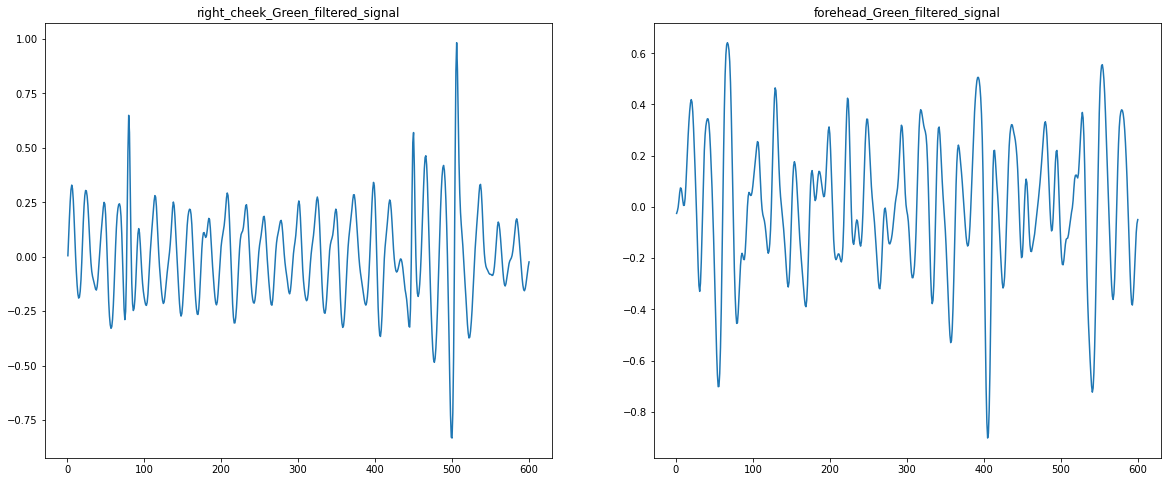

In [ ]:
if __name__ == '__main__':
  # Apply bandpass filter to the three signals
  right_cheek_filtered = bandpass_filter(right_cheek_Green_Avg[1], low_cutoff=0.8, high_cutoff=3, fs=30, order=1)
  forehead_filtered = bandpass_filter(forehead_Green_Avg[1], low_cutoff=0.8, high_cutoff=3, fs=30, order=1)
  
  # Create x-axis values for the three signals
  x1 = np.arange(1, len(right_cheek_filtered)+1)
  x2 = np.arange(1, len(forehead_filtered)+1)
  
  # Combine x-axis values in a list
  X = [x1, x2]

  # Plot the filtered signal on the corresponding subplot
  fig, ax = plt.subplots(1, 2, figsize=(20, 8))
  output_signals = [right_cheek_filtered, forehead_filtered]
  titles = ['right_cheek_Green_filtered_signal', 'forehead_Green_filtered_signal']
  for i in range(len(output_signals)):
    ax[i].plot(X[i], output_signals[i])
    ax[i].set_title(titles[i])
  plt.show()

##3.4 Plot Fourier spectra
Plot the Fourier magnitudes of these two signals using the **DFT**, where the x-axis is frequency (in Hertz) and y-axis is amplitude. DFT coefficients are ordered in terms of integer indices, so you will have to convert the indices into Hertz. For each index n = [-N/2, N/2], the corresponding frequency is Fs * n / N, where N is the length of your signal and Fs is the sampling rate of the signal (30 Hz in this case). You can use **numpy.fftfreq** to do this conversion for you.

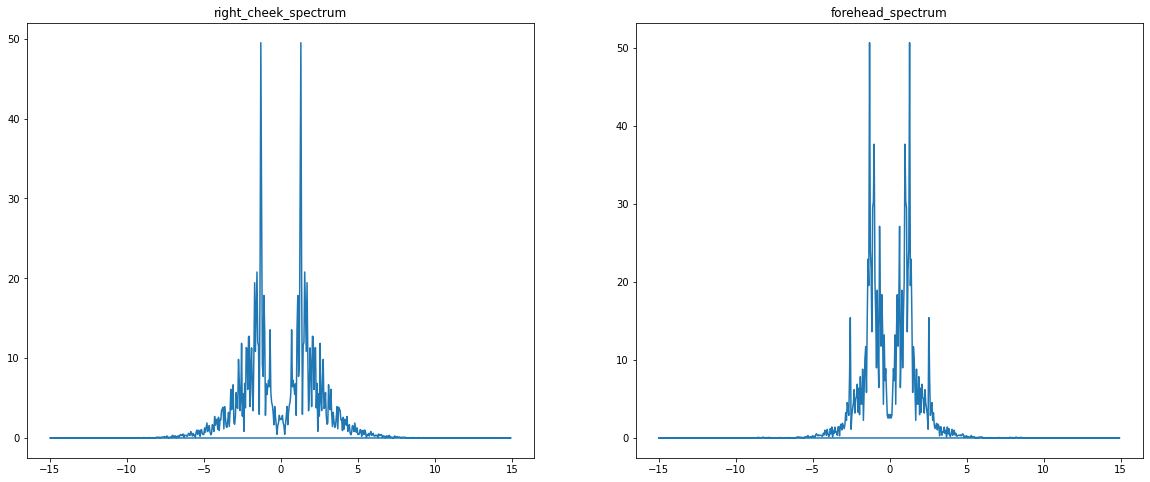

In [ ]:
if __name__ == '__main__':
  # Compute the FFT of the filtered signals of the right cheek, and forehead
  right_cheek_fourier = np.abs(np.fft.fft(right_cheek_filtered))
  right_cheek_frequency = np.fft.fftfreq(right_cheek_fourier.size, d=1) * 30

  forehead_fourier = np.abs(np.fft.fft(forehead_filtered))
  forehead_frequency = np.fft.fftfreq(forehead_fourier.size, d=1) * 30

  # List of frequency values corresponding to the filtered signals
  X = [right_cheek_frequency, forehead_frequency]

  # Plot the spectrum signals of the right cheek, and forehead
  fig, ax = plt.subplots(1, 2, figsize=(20, 8))
  output_signals = [right_cheek_fourier, forehead_fourier]
  titles = ['right_cheek_spectrum', 'forehead_spectrum']
  for i in range(len(output_signals)):
    ax[i].plot(X[i], output_signals[i])
    ax[i].set_title(titles[i])
  plt.show()

##3.5 Estimate Alice’s average pulse rate
A normal resting heart rate for adults ranges between 60-100 beats per minute. What rate does the highest peak in Alice’s Fourier spectrum correspond to? Which facial region provides the cleanest spectrum (the one which has the clearest single peak and low energy elsewhere)? Is Alice likely a human or not?

In [ ]:
def get_heart_rate(fourier_signal, frequency):
  '''
  Parameters:
    fourier_signal (ndarray): the fourier transform of the signal
    frequency (ndarray): the corresponding frequencies of the fourier transform

  Returns:
    tuple: a tuple of the maximum peak frequency and the calculated heart rate (in beats per minute)
  '''
  peaks, _ = find_peaks(fourier_signal)
  max_peak = peaks[np.argmax(fourier_signal[peaks])]
  max_peak_frequency = frequency[max_peak]
  heart_rate = max_peak_frequency * 60

  return max_peak_frequency, heart_rate

In [ ]:
if __name__ == '__main__':
  # Calculate the heart rate from the fourier_signals and frequency
  right_cheek_heart_rate = get_heart_rate(right_cheek_fourier, right_cheek_frequency)
  forehead_heart_rate = get_heart_rate(forehead_fourier, forehead_frequency)

  # Print the results of the heart rate calculation for the right cheek, and forehead
  print("right cheek max peak frequency:", right_cheek_heart_rate[0], "Hz = ", right_cheek_heart_rate[1], "BPM")
  print("forehead max peak frequency:", forehead_heart_rate[0], "Hz = ", forehead_heart_rate[1], "BPM")

right cheek max peak frequency: 1.3 Hz =  78.0 BPM
forehead max peak frequency: 1.3 Hz =  78.0 BPM


##3.6 Find your own pulse
Take a 15-20 second video of yourself using a smartphone, webcam, or personal camera. Your face should be as still as possible, and don’t change facial expressions. Do a similar analysis above as you did with Alice’s video. Show some frames from your video. Was it easier/harder to estimate heart rate compared to the sample video we provided? What was challenging about it?

Can't receive frame (stream end?). Exiting ...


<Figure size 432x288 with 0 Axes>

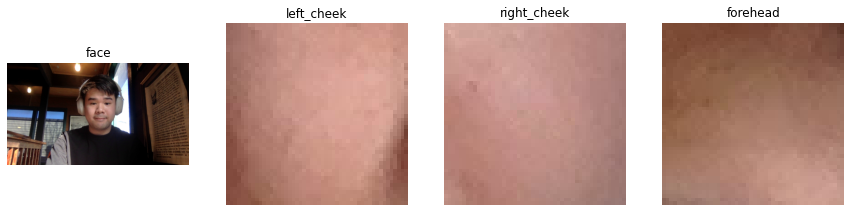

In [ ]:
if __name__ == "__main__":
  # read selfie video into numpy array
  selfie_video = read_video_into_numpy(path+"selfie.mov")

  # get 1st frame of the video
  face = selfie_video[0]

  # extract the cheek and forehead portions of the first frame of the video
  left_cheek = extract_image(video = selfie_video, x = [320,370], y = [570,620]) # (video, ↕[x-axis], ↔[y-axis])
  right_cheek = extract_image(video = selfie_video, x = [320,370], y = [700,750]) # (video, ↕[x-axis], ↔[y-axis])
  forehead = extract_image(video = selfie_video, x = [200,250], y = [600,650]) # (video, ↕[x-axis], ↔[y-axis])
  
  # Display image face, left_cheek, right_cheek and forehead
  plt.figure()
  fig, ax = plt.subplots(1, 4, figsize=(15, 15))
  output_images = [face, left_cheek, right_cheek, forehead]
  titles = ['face', 'left_cheek', 'right_cheek', 'forehead']
  index = 0
  for i in range(4):
    ax[i].imshow(output_images[index], cmap="gray")
    ax[i].axis('off')
    ax[i].set_title(titles[i])
    index += 1

<Figure size 432x288 with 0 Axes>

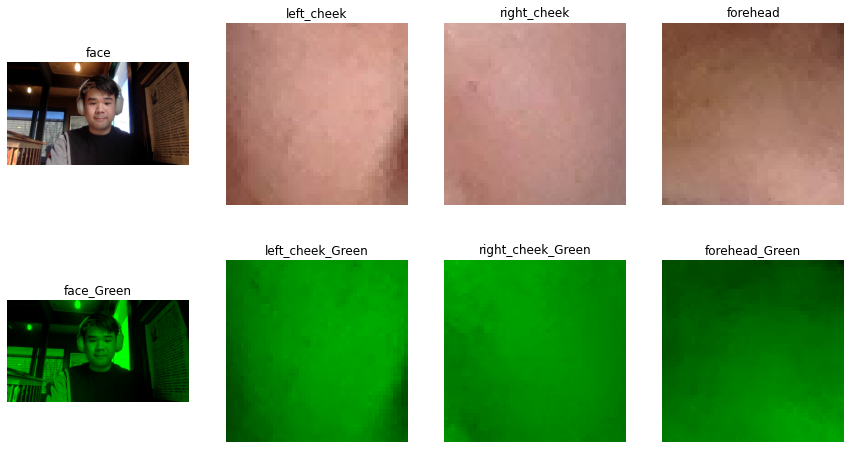

In [ ]:
if __name__ == '__main__':
  # Compute green signals from the Alice video for different regions: face, left cheek, right cheek, and forehead
  face_Green_Avg = compute_signals(video = selfie_video, x = [0,720], y = [0,1280])
  left_cheek_Green_Avg = compute_signals(video = selfie_video, x = [320,370], y = [570,620])
  right_cheek_Green_Avg = compute_signals(video = selfie_video, x = [320,370], y = [700,750])
  forehead_Green_Avg = compute_signals(video = selfie_video, x = [200,250], y = [600,650])
  
  # Display image face_Green, left_cheek_Green, right_cheek_Green and forehead_Green
  plt.figure()
  fig, ax = plt.subplots(2, 4, figsize=(15, 8)) 
  output_images = [face, left_cheek, right_cheek, forehead,
            face_Green_Avg[0], left_cheek_Green_Avg[0], right_cheek_Green_Avg[0], forehead_Green_Avg[0]]
  titles = ['face', 'left_cheek', 'right_cheek', 'forehead',
        'face_Green', 'left_cheek_Green', 'right_cheek_Green', 'forehead_Green']
  index = 0
  for i in range(2):
    for j in range(4):
      ax[i][j].imshow(output_images[index], cmap="gray")
      ax[i][j].axis('off')
      ax[i][j].set_title(titles[index])
      index += 1

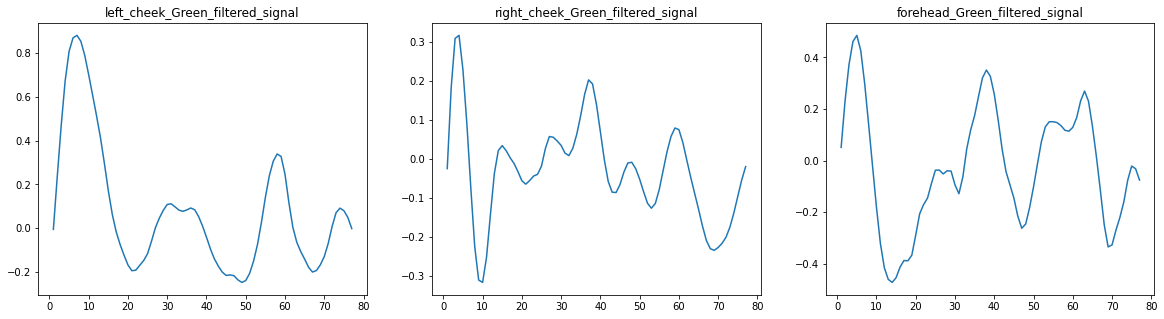

In [ ]:
if __name__ == '__main__':
  # Apply bandpass filter to the three signals
  left_cheek_filtered = bandpass_filter(left_cheek_Green_Avg[1], low_cutoff=0.8, high_cutoff=3, fs=30, order=1)
  right_cheek_filtered = bandpass_filter(right_cheek_Green_Avg[1], low_cutoff=0.8, high_cutoff=3, fs=30, order=1)
  forehead_filtered = bandpass_filter(forehead_Green_Avg[1], low_cutoff=0.8, high_cutoff=3, fs=30, order=1)
  
  # Create x-axis values for the three signals
  x1 = np.arange(1, len(left_cheek_filtered)+1)
  x2 = np.arange(1, len(right_cheek_filtered)+1)
  x3 = np.arange(1, len(forehead_filtered)+1)
  
  # Combine x-axis values in a list
  X = [x1, x2, x3]

  # Plot the filtered signal on the corresponding subplot
  fig, ax = plt.subplots(1, 3, figsize=(20, 5))
  output_signals = [left_cheek_filtered, right_cheek_filtered, forehead_filtered]
  titles = ['left_cheek_Green_filtered_signal', 'right_cheek_Green_filtered_signal', 'forehead_Green_filtered_signal']
  for i in range(len(output_signals)):
    ax[i].plot(X[i], output_signals[i])
    ax[i].set_title(titles[i])
  plt.show()

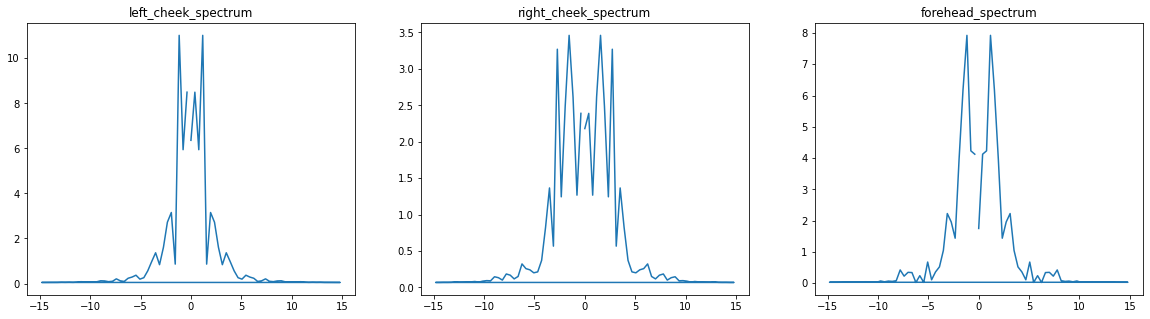

In [ ]:
if __name__ == '__main__':
  # Compute the FFT of the filtered signals of the left cheek, right cheek, and forehead
  left_cheek_fourier = np.abs(np.fft.fft(left_cheek_filtered))
  left_cheek_frequency = np.fft.fftfreq(left_cheek_fourier.size, d=1) * 30

  right_cheek_fourier = np.abs(np.fft.fft(right_cheek_filtered))
  right_cheek_frequency = np.fft.fftfreq(right_cheek_fourier.size, d=1) * 30
  
  forehead_fourier = np.abs(np.fft.fft(forehead_filtered))
  forehead_frequency = np.fft.fftfreq(forehead_fourier.size, d=1) * 30

  # List of frequency values corresponding to the filtered signals
  X = [left_cheek_frequency, right_cheek_frequency, forehead_frequency]

  # Plot the spectrum signals of the left cheek, right cheek, and forehead
  fig, ax = plt.subplots(1, 3, figsize=(20, 5))
  output_signals = [left_cheek_fourier, right_cheek_fourier, forehead_fourier]
  titles = ['left_cheek_spectrum', 'right_cheek_spectrum', 'forehead_spectrum']
  for i in range(len(output_signals)):
    ax[i].plot(X[i], output_signals[i])
    ax[i].set_title(titles[i])
  plt.show()

In [ ]:
if __name__ == '__main__':
  # Calculate the heart rate from the fourier_signals and frequency
  left_cheek_heart_rate = get_heart_rate(left_cheek_fourier, left_cheek_frequency)
  right_cheek_heart_rate = get_heart_rate(right_cheek_fourier, right_cheek_frequency)
  forehead_heart_rate = get_heart_rate(forehead_fourier, forehead_frequency)

  # Print the results of the heart rate calculation for the left cheek, right cheek, and forehead
  print("left cheek max peak frequency:", left_cheek_heart_rate[0], "Hz = ", left_cheek_heart_rate[1], "BPM")
  print("right cheek max peak frequency:", right_cheek_heart_rate[0], "Hz = ", right_cheek_heart_rate[1], "BPM")
  print("forehead max peak frequency:", forehead_heart_rate[0], "Hz = ", forehead_heart_rate[1], "BPM")

left cheek max peak frequency: 1.1688311688311688 Hz =  70.12987012987013 BPM
right cheek max peak frequency: 1.5584415584415585 Hz =  93.50649350649351 BPM
forehead max peak frequency: 1.1688311688311688 Hz =  70.12987012987013 BPM
